# The Impact of Weather Data on Cbot Corn Futures Price Prediction

Team Members - section 003
- Yutian Wang(#85994168): Yutian contributed to data cleaning, formatting, standardization, visualization, and time-series analysis.
- Ronin Cunningham(#43949676): Ronin contributed by implementing the PyTorch neural network, making the SHAP visualization, and bar graph.
- Prayus Shrestha(#55823454): Prayus contributed by gathering the data through scraping and various APIs, and preparing it into a usable format.
- Ebin Tomy(#44912301): Ebin contributed by writing the background, literature review, research layout, model results and conclusion section.

## Background

The agriculture commodity market is an important part of the economic system. The futures market helps farmers by providing liquidity, price guidance and the ability to manage market price fluctuations. Traders provide this liquidity and seek to profit from fluctuations in the market but are faced with incomplete information. As identified by [Zhou et. al (2022)](https://ieeexplore.ieee.org/document/9898176), futures prices depend on various factors and can be affected by shocks to production levels and changes in policy decisions. As such, solely considering historical price as the single input factor is insufficient to predict commodity prices considering market volatility. This project aims to apply machine-learning methods to measure the influence of weather data on corn futures prices in the U.S. 




## Literature Review

Zhou et. al (2022) lays out a basic framework of using ML models to consider multiple input factors for price prediction of a basket of commodities (corn, oats, soybeans, and soybean oil). This paper uses four multiple-input feature models: LSTM, RNN, and GRU. Their advanced improved LSTM model produced the best accuracy. In their analysis, they single out weather to be a significant factor since crop production is heavily dependent. [Sriramjee (2022)](https://www.proquest.com/openview/5830a713adc5a58d3a33b2cf824eeb44/1?pq-origsite=gscholar&cbl=18750&diss=y) builds on this premise by using CNN, RNN (LSTM), SVM, and Logistic Regression models among others to  predict percentage change in daily, weekly and weekend Chicago Board of Trade (CBOT) corn futures prices. While the prediction models that were generated showed differences from actual data, weather-related data points were shown to have notably increased accuracy in the predictions. To this point, [Gopinath et al. (2021)](https://www.cambridge.org/core/journals/data-and-policy/article/international-agricultural-trade-forecasting-using-machine-learning/0AB17DA0D2BD6E72274232656BA29B91) has shown that there is great variation in results depending on the choice of different ML techniques in forecasting international agricultural trade.




## Research Layout

Using the established literature and the techniques we learnt in class as a starting point, we will estimate the impact of weather on Cbot corn futures prices. 

### Data

- We look at data for the period of 2019-2023
- Weather - we will be looking at two aspects of weather in our model: temperature and precipitation. This is because corn production grows well in tropical conditions in which the weather is hot and humid. Hot and dry weather has a negative impact on its growth. We gather our weather data from Iowa, since the state has been ranked #1 in corn production in the U.S since 1994.
- Controls - We will be controlling for covariates such as oil, which is a proxy for transportation costs. We account for all encompassing material costs and inflation of prices felt by farmers using the proxy of the price of lumber. 
- Correlation - Wheat and corn are highly related to each other in terms of supply and demand relationships. In general, the price of corn and the supply of wheat are inversely correlated. This means that as the supply of wheat increases, the price of corn decreases. Therefore, we added wheat price as a feature in our dataset for our ML models. This relationship is seen for oat prices as well. 
- Lagged Variables - For each of the models, we used lagged-based variables to study the impact of past variable values on the future values. For instance, if a current temperature impacts future crop prices, this will be seen here. We used a 1, 7, 30, and 365 day lag. We also used an 84 day lag for corn, since this is the length of its growth cycle. These variaables are used to enforce Auto-regressive features for accurate results. 


### ML Models

We used 3 Neural Nets 
1. Multilayer perceptron (MLP)
2. Standard Recurrent Neural Network (RNN) with an Adam optimizer and L2 Regularization
3. Gated recurrent units (GRU) with an Adam optimizer and L2 Regularization


## Data Cleaning and Formatting

In [17]:
# !pip install torchvision 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from rnn_model import RNNModel
from sklearn.metrics import mean_absolute_error, mean_squared_error
from gru_model import GRUModel
import shap

%matplotlib inline

TO-DO: incorporate Prayus' data scrapping section here

TO-DO: add description for these two data sets. source? meaning of each column? 

The first step will be to read in the data from the `data/` folder. This data was scraped from various APIs online (details are in the [`./data_scraper.ipynb`](https://github.com/PrayusShrestha/crop-price-prediction/blob/master/src/data_scraper.ipynb) notebook. We'll start by loading in the weather data, then moving to loading in commodity data. 

In [46]:
# Reading in the weather data 
weather_df = pd.read_csv('../data/weather_data.csv', index_col=0)
weather_df.head()

,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum
0,2000-03-24,12.6,-6.6,5.7,0.0
1,2000-03-25,15.0,-1.0,8.7,0.0
2,2000-03-26,18.7,2.4,11.2,0.0
3,2000-03-27,22.9,1.5,14.8,0.0
4,2000-03-28,22.8,7.2,14.8,0.0


We want to make some changes to this dataframe - we will turn the `time` column into the index as it is the date, then only keep the mean temperature and precipitation sum columns. 

In [19]:
# Setting index to be the date
weather_df.index = pd.to_datetime(weather_df["time"])
weather_df.index.name = "date"
weather_df["date"] = pd.to_datetime(weather_df.index)

# Only keeping daily mean temperature and precipitation sum
weather_df = weather_df[["temperature_2m_mean", "precipitation_sum"]]
weather_df.head()

,temperature_2m_mean,precipitation_sum
date,,
2000-03-24,5.7,0.0
2000-03-25,8.7,0.0
2000-03-26,11.2,0.0
2000-03-27,14.8,0.0
2000-03-28,14.8,0.0


We will now read in the data from the various commodities. 

In [20]:
# Reading in commodity data
oil_df = pd.read_csv("../data/crude_oil.csv", index_col=0)
lumber_df = pd.read_csv("../data/lumber_data.csv", index_col=0)
oat_df = pd.read_csv("../data/oat_data.csv", index_col=0)
wheat_df = pd.read_csv("../data/wheat_data.csv", index_col=0)
corn_df = pd.read_csv("../data/corn_data.csv", index_col = 0)

In [21]:
# Without loss of generality, showing the corn_df
corn_df.head()

,open,close,high,low
2023-04-20,636.50,626.50,637.25,622.00
2023-04-19,675.75,672.25,680.00,671.00
2023-04-18,676.00,677.50,682.50,669.75
2023-04-17,666.00,676.50,677.00,662.25
2023-04-16,635.00,634.75,635.75,634.00


We'll want to transform these commodity dataframes to something more useable. The `clean_commodity_df` function below performs the necessary transformations: the index is set to be the date, a "price" column is made to be the midpoint between the high and low daily prices, NAs are dropped, and the dataframe is sorted according to date. 

In [22]:
def clean_commodity_df(df: pd.DataFrame, price_col_name: str = "price") -> pd.DataFrame: 
    """Cleans the Commodity DataFrame"""
    
    # Setting the index to be the date
    df.index = pd.to_datetime(df.index)
    df.index.name = "date"
    
    # Setting price to be the day's midpoint, and dropping unnecessary columns
    df[price_col_name] = (df["high"] + df["low"]) / 2 
    df = df[[price_col_name]]
    df = df.dropna() 

    # Sorting by date
    df = df.sort_index()
    return df

In [23]:
# Cleaning the commodity dataframes
corn_df = clean_commodity_df(df=corn_df, price_col_name="corn_price")
oil_df = clean_commodity_df(df=oil_df, price_col_name="oil_price")
lumber_df = clean_commodity_df(df=lumber_df, price_col_name="lumber_price")
oat_df = clean_commodity_df(df=oat_df, price_col_name="oat_price")
wheat_df = clean_commodity_df(df=wheat_df, price_col_name="wheat_price")

Now that we have usable dataframes for our features, we want to combine them into one dataframe.

In [24]:
# Merging features
X = pd.concat([oil_df, lumber_df, oat_df, wheat_df, weather_df], axis=1).dropna()
X.head()

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum
date,,,,,,
2018-04-24,68.459999,551.500000,221.250,485.625,20.4,0.0
2018-04-25,67.645001,558.200012,224.375,501.125,21.7,0.0
2018-04-26,68.244999,559.800018,220.875,502.500,23.5,0.0
2018-04-27,68.000000,567.600006,220.875,506.625,21.6,0.0
2018-04-30,68.254997,575.500000,224.625,517.750,15.3,0.0


An interesting observation is that weather may not have an immediate impact on corn prices, but instead impact future prices. To factor that in, we're introducing lag variables; more specifically, to predict corn prices on day $i$, we're looking at temperature and precipitation prices from days $i, i-1, i-7, i-30, i-84,$ and $i-365$. These values correspond with the previous day, week, month, and year, along with 84 days = 12 weeks which is the average time it takes to grow corn. 

In [25]:
# Lag variables 
lags = [1, 7, 30, 84, 365] # day, week, month, 84 days, year

# Creating lags in df
for lag in lags: 
    X[f"temp_lag_{lag}"] = X["temperature_2m_mean"].shift(lag)
    X[f"precip_lag_{lag}"] = X["precipitation_sum"].shift(lag)

X.dropna(inplace=True)
X.head()

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum,temp_lag_1,precip_lag_1,temp_lag_7,precip_lag_7,temp_lag_30,precip_lag_30,temp_lag_84,precip_lag_84,temp_lag_365,precip_lag_365
date,,,,,,,,,,,,,,,,
2019-10-04,52.694999,364.700012,289.750,406.250,15.3,0.0,14.7,0.0,22.6,0.0,24.7,0.0,25.0,0.0,20.4,0.0
2019-10-07,53.325001,370.600006,284.500,404.875,15.9,0.0,15.3,0.0,22.2,0.0,25.8,0.0,26.8,0.1,21.7,0.0
2019-10-08,52.540001,364.800003,282.750,405.500,15.7,0.0,15.9,0.0,22.5,0.0,25.0,0.0,23.2,0.0,23.5,0.0
2019-10-09,53.025002,364.850006,283.000,412.625,15.0,0.0,15.7,0.0,21.8,0.0,25.4,0.0,27.3,0.0,21.6,0.0
2019-10-10,52.675001,365.850006,287.125,408.750,14.2,0.0,15.0,0.0,17.2,0.0,28.1,0.0,28.4,0.0,15.3,0.0


It seems quite logical that corn prices on a certain day also depend on their historical prices. To model this, we are introducing autoregressive terms into our features dataframe.

In [26]:
# Adding autoregressive component 
X = X.merge(corn_df, on="date")
X["AR1_corn_price"] = X["corn_price"].shift(1)
X.drop("corn_price", axis=1, inplace=True)
X.dropna(inplace=True)
X.head(3)

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum,temp_lag_1,precip_lag_1,temp_lag_7,precip_lag_7,temp_lag_30,precip_lag_30,temp_lag_84,precip_lag_84,temp_lag_365,precip_lag_365,AR1_corn_price
date,,,,,,,,,,,,,,,,,
2019-10-07,53.325001,370.600006,284.50,404.875,15.9,0.0,15.3,0.0,22.2,0.0,25.8,0.0,26.8,0.1,21.7,0.0,386.375
2019-10-08,52.540001,364.800003,282.75,405.500,15.7,0.0,15.9,0.0,22.5,0.0,25.0,0.0,23.2,0.0,23.5,0.0,386.375
2019-10-09,53.025002,364.850006,283.00,412.625,15.0,0.0,15.7,0.0,21.8,0.0,25.4,0.0,27.3,0.0,21.6,0.0,391.250


Our features are properly cleaned now. Unfortunately, we have lost some columns due to NA values. This means that our target crop price dataframe doesn't properly line up with our features dataframe. To fix this we will remove rows in the crop price dataframe that don't have a matching date in the features dataframe.

In [27]:
y = X.join(corn_df, how="inner")["corn_price"]

In [28]:
X.head()

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum,temp_lag_1,precip_lag_1,temp_lag_7,precip_lag_7,temp_lag_30,precip_lag_30,temp_lag_84,precip_lag_84,temp_lag_365,precip_lag_365,AR1_corn_price
date,,,,,,,,,,,,,,,,,
2019-10-07,53.325001,370.600006,284.500,404.875,15.9,0.0,15.3,0.0,22.2,0.0,25.8,0.0,26.8,0.1,21.7,0.0,386.375
2019-10-08,52.540001,364.800003,282.750,405.500,15.7,0.0,15.9,0.0,22.5,0.0,25.0,0.0,23.2,0.0,23.5,0.0,386.375
2019-10-09,53.025002,364.850006,283.000,412.625,15.0,0.0,15.7,0.0,21.8,0.0,25.4,0.0,27.3,0.0,21.6,0.0,391.250
2019-10-10,52.675001,365.850006,287.125,408.750,14.2,0.0,15.0,0.0,17.2,0.0,28.1,0.0,28.4,0.0,15.3,0.0,395.125
2019-10-11,54.284999,368.350006,289.000,412.875,13.3,0.1,14.2,0.0,14.1,0.0,27.5,0.0,18.7,0.6,19.2,0.0,386.625


## Model Training and Inference
Now we can start training our models. We'll start by splitting our data into a train/test split, with 80% of the data being reserved for training, and 20% for testing; this ensures that we have enough data to train a model, but also enough to properly validate our results. As many of the features are on different scales, we standardize them to make them comparable. Variables that have large values, can dominate the analysis if they are not standardized, so we'll use the `StandardScaler()` to give each feature a mean of 0 and standard deviation of 1.  

In [29]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Scaling inputs based on training data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Our first thought was to use an auto-regressive linear regression model. When we started doing some explanatory data visualizations (select plots below), we quickly realized that most of the features did not have a linear relationship with the corn price:

Text(0.5, 1.0, 'Precipitation vs. Avg. Corn Price')

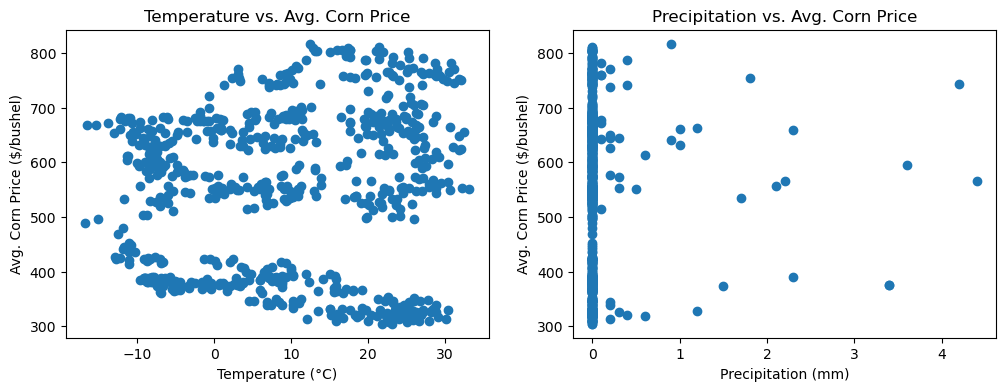

In [30]:
# Plotting weather data vs. corn price
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(X_train['temperature_2m_mean'], y_train)
axs[0].set_xlabel('Temperature (°C)')
axs[0].set_ylabel('Avg. Corn Price ($/bushel)')
axs[0].set_title('Temperature vs. Avg. Corn Price')

axs[1].scatter(X_train['precipitation_sum'], y_train)
axs[1].set_xlabel('Precipitation (mm)')
axs[1].set_ylabel('Avg. Corn Price ($/bushel)')
axs[1].set_title('Precipitation vs. Avg. Corn Price')

In [31]:
corr_matrix = X_train[['AR1_corn_price', 'temperature_2m_mean', 'precipitation_sum']].corr()
print(corr_matrix)

                     AR1_corn_price  temperature_2m_mean  precipitation_sum
AR1_corn_price             1.000000             0.069840           0.013824
temperature_2m_mean        0.069840             1.000000          -0.002194
precipitation_sum          0.013824            -0.002194           1.000000


<AxesSubplot:>

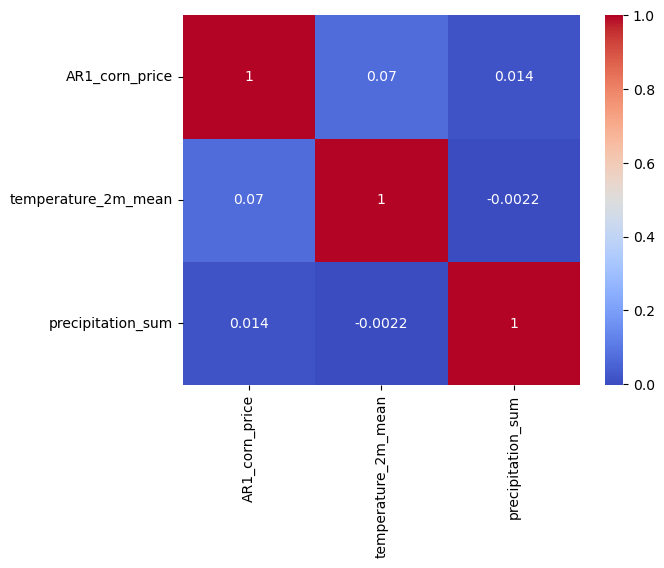

In [32]:
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

Based on the results, there doesn't seem to be a strong correlation between temperature and precipitation with corn prices. It's also possible that the relationship between weather and corn prices is more complex than a simple linear relationship, and may require further analysis to uncover.

### MLP Regression

Our first attempt at a model then was to fit a multi-layer perceptron. This neural network will have $2, 100 \times 100$ fully connected hidden layers and use the default ReLU activation function (`relu(x) = max(x, 0)`). 

In [33]:
# Initializing and fitting the MLP to scaled
mlp = MLPRegressor((100, 100), random_state=123, max_iter=10000)
mlp.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=123)

Text(0.5, 1.0, "Actual Crop Prices Compared to MLP's Prediction")

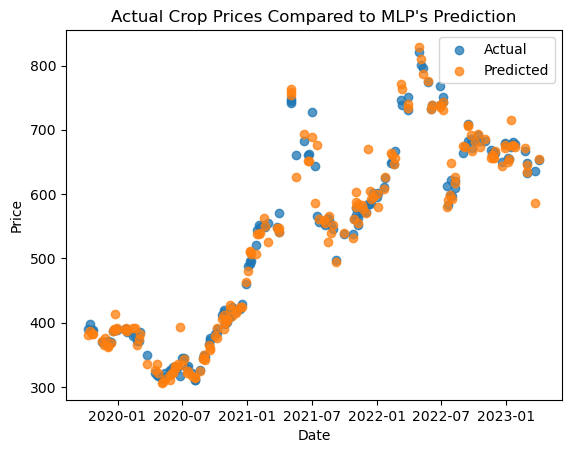

In [34]:
# Plotting actual vs. predicted
plt.scatter(X_test.index, y_test, alpha=0.75)
plt.scatter(X_test.index, mlp.predict(X_test_scaled), alpha=0.75)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(["Actual", "Predicted"])
plt.title("Actual Crop Prices Compared to MLP's Prediction")

In [35]:
mse_mlp = mean_squared_error(y_test, mlp.predict(X_test_scaled))
rmse_mlp = np.sqrt(mse_mlp)
print(f"MSE of MLPRegressor: {mse_mlp}")
print(f"RMSE of MLPRegressor: {rmse_mlp}")

MSE of MLPRegressor: 320.84403792800293
RMSE of MLPRegressor: 17.912119861367692


The scatter plot above shows how the MLP is able to predict the pattern of the corn prices fairly accurately. Formally, The MLP Regressor showed a mean squared error of ~321 and an RMSE of ~18. 

We'll use more complicated neural network architectures below to see if we can get a better result. 

### Recurrent Neural Network (RNN) Regression

TODO: explanation

#### Setup the input data

In [36]:
# Set seed for reproducability
torch.manual_seed(0)

# Prepare the train dataset
input_size = 17
output_size = 1
sequence_length = 1

X_train_arr = np.array(X_train_scaled)
y_train_arr = np.array(y_train)

X_train_arr = X_train_arr.reshape(-1, sequence_length, input_size)
y_train_arr = y_train_arr.reshape(-1, sequence_length, output_size)

# Prepare the test dataset
X_test_arr = np.array(X_test_scaled)
y_test_arr = np.array(y_test)

X_test_arr = X_test_arr.reshape(-1, sequence_length, input_size)
y_test_arr = y_test_arr.reshape(-1, sequence_length, output_size)

train_dataset = TensorDataset(torch.tensor(X_train_arr).float(), torch.tensor(y_train_arr).float())
test_dataset = TensorDataset(torch.tensor(X_test_arr).float(), torch.tensor(y_test_arr).float())

#### Basic RNN model with Adam optimizer and L2 regularization

##### Training

First, we need to set hyperparameters for our RNN model. After experimenting with various different configurations, below are the hyperparameters that I found to be best

In [37]:
# Set hyperparameters TODO: Play around with these
hidden_size = 64
num_epochs = 1000
batch_size = 32
learning_rate = 0.001

In [38]:
# Load the training data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
rnn_model_instance = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model_instance.parameters(), lr=learning_rate, weight_decay=1e-5)  # Add weight_decay for L2 regularization

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = rnn_model_instance(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

##### Testing

In [39]:
# Load the testing data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
rnn_model_instance.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = rnn_model_instance(inputs)
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(targets.numpy().flatten())

# Calculate accuracy metrics
mae_rnn = mean_absolute_error(actuals, predictions)
mse_rnn = mean_squared_error(actuals, predictions)
rmse_rnn = np.sqrt(mse_rnn)

print(f'Mean Absolute Error: {mae_rnn:.4f}')
print(f'Mean Squared Error: {mse_rnn:.4f}')
print(f'Root Mean Squared Error: {rmse_rnn:.4f}')

Mean Absolute Error: 10.1053
Mean Squared Error: 254.9118
Root Mean Squared Error: 15.9660


#### GRU model with Adam optimizer and L2 Regularization

##### Training

In [40]:
# Set hyperparameters TODO: Play around with these
hidden_size = 64
num_epochs = 1000
batch_size = 32
learning_rate = 0.001

In [41]:
# Load the training data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
gru_model_instance = GRUModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model_instance.parameters(), lr=learning_rate, weight_decay=1e-5)

# Train the modelt
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = gru_model_instance(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


##### Testing

In [42]:
# Load the testing data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
gru_model_instance.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = gru_model_instance(inputs)
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(targets.numpy().flatten())

# Calculate accuracy metrics
mae_gru = mean_absolute_error(actuals, predictions)
mse_gru = mean_squared_error(actuals, predictions)
rmse_gru = np.sqrt(mse_gru)

print(f'Mean Absolute Error: {mae_gru:.4f}')
print(f'Mean Squared Error: {mse_gru:.4f}')
print(f'Root Mean Squared Error: {rmse_gru:.4f}')

Mean Absolute Error: 9.3832
Mean Squared Error: 234.8087
Root Mean Squared Error: 15.3235


## Model Results

### Comparison of ML Models

Our first model was the Multi layer Perceptron (MLP) model. It performed quite well with an MSE of ~321 and a RMSE of 17.9 for the MLP regressor. The scatter plot above shows our predicted model fits the actual model quite well. 

For better results we tried a basic Recurrent Neural Network (RNN) model with Adam optimizer and L2 regularization. The L2 regularization reduces over-fitting. Again, it performed well with a MSE of ~255 and a RMSE of ~16. Since this model was a basic one provided by pytroch, we wanted to experiment with the more complicated GRU model for better results. 

Our third model is the GRU model with Adam optimizer and L2 Regularization. This model performed the best, with a MSE of ~235 and a RMSE of ~15. 


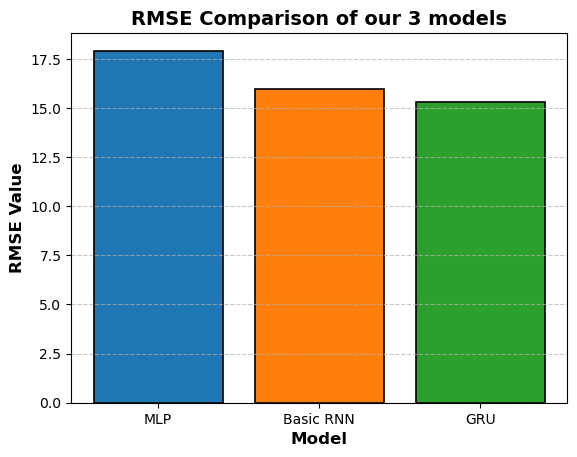

In [45]:
# Setup variables
labels = ['MLP', 'Basic RNN', 'GRU']
values = [rmse_mlp, rmse_rnn, rmse_gru]
plt.bar(labels, values)

# Create the bar graph with some nice colours
colors = ['#1F77B4', '#FF7F0E', '#2CA02C']
plt.bar(labels, values, color=colors, edgecolor='black', linewidth=1.2)

# Add a title and labels
plt.title('RMSE Comparison of our 3 models', fontweight='bold', fontsize=14)
plt.xlabel('Model', fontweight='bold', fontsize=12)
plt.ylabel('RMSE Value', fontweight='bold', fontsize=12)

plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Shapley values of our GRU Model

Permutation explainer: 178it [00:24,  5.92it/s]                         


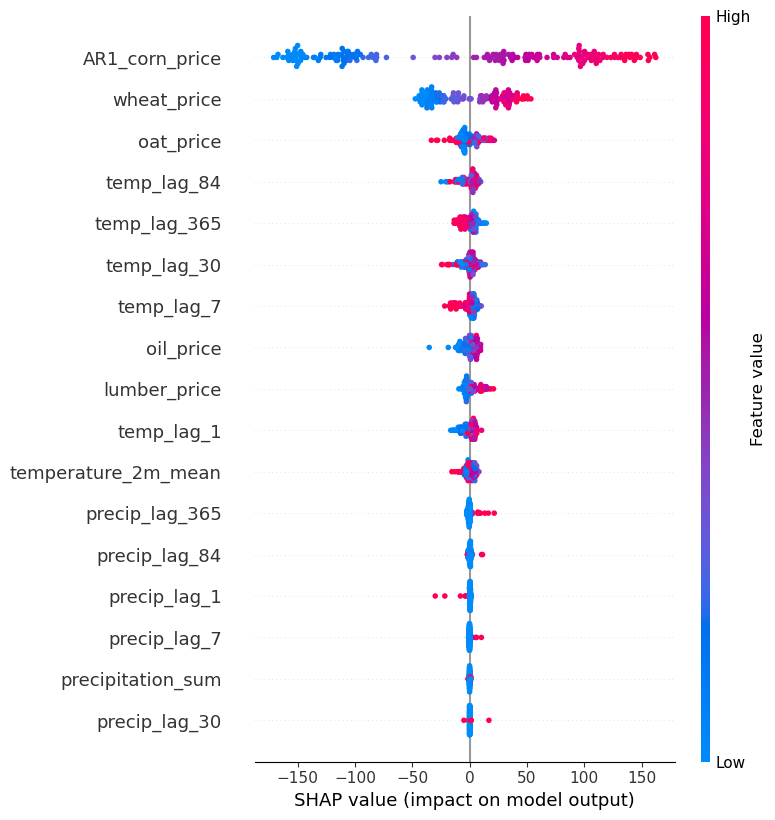

In [43]:
best_model = rnn_model_instance if rmse_rnn <= rmse_gru else gru_model_instance

def model_wrapper(x):
    x_tensor = torch.FloatTensor(x).unsqueeze(1)
    with torch.no_grad():
        output = best_model(x_tensor)
    return output.numpy()

# Initialize the explainer
explainer = shap.Explainer(model_wrapper, X_train_scaled)

# Compute SHAP values for X_test
shap_values = explainer(X_test_scaled)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

Our Shapley Values graph reveals some interesting insights:
- The y-axis ranks variables in order of importance. We see that our AR1 variable for corn price is the most important feature, with wheat prices and oat prices coming after. Below we see weather related variables like temperature. Precipitation is near the bottom, indicating that perhaps it is less important than temperature for corn futures prices. WE see that weather factors of corn production supply are not as important as other futures price data. This signals that perhaps wheat and oat prices capture other important features we may not have considered.
- On the x axis we can see the SHAP values of each feature. Our AR1 corn price variable shows that it has a high positive impact on corn price prediction. This makes sense since if your lagged price is high, your current price and be predicated to stay high. Our wheat price variable SHAP values show that it has a high and positive impact on corn prices. This makes sense given the inverse relationship we outlined above between corn price and wheat supply. 




## Conclusion

To predict the impact of weather data on Cbot Corn Futures prices, we collected data from 2019 to 2021, pre-processed it, and used it to train three different multi-input models (MLP, standard RNN and GRU). Among them, the GRU model displayed the best performance and accuracy. 

As seen by the results of our model, weather factor inputs such as precipitation and temperature have a notable impact on corn production and therefore corn futures prices. Our best performing model. We see from our results that while weather has a noticeable impact on corn futures prices, our AR1 price variable had a bigger impact in predicting corn futures prices. 

### Limitations

- We only had access to weather data from Iowa while CBOT futures prices are impacted by supply shocks in production from other states with large corn production such as Ians, Nebraska, and Minnesota
- As seen in Gopinath et al. (2021), the results from deep-learning models, like Neural Nets, we have used in this study are hard to validate and can be a “black box.” NNs seem to work best for long-term forecasting. 
- A significant factor that limited the explanatory power of our model is the lack of granularity in our weather data. The data was on the state-level, but as seen in Sriramjee (2022), the explanatory power of weather on price movements diminishes without access to weather forecasts at the county level. Access to this level of granular data is hard to come by and expensive. 
- Our control of lumber prices to account for inflation and material costs faced by farmers is simplistic.


### Areas for further research

While weather data does augment price prediction it does not capture the whole picture. International agriculture trade data can provide important information on price determination not considered in this study. Furthermore, sentiment text analysis on documents on U.S agriculture policy decision changes and economy-wide news can fill information gaps in the model. 

## References

J. Zhou, J. Ye, Y. Ouyang, M. Tong, X. Pan and J. Gao, "On Building Real Time Intelligent Agricultural Commodity Trading Models," 2022 IEEE Eighth International Conference on Big Data Computing Service and Applications (BigDataService), Newark, CA, USA, 2022, pp. 89-95, doi: 10.1109/BigDataService55688.2022.00021.

Singh, S. (2022). Estimating the impact of weather on CBOT corn futures prices using machine learning (Doctoral dissertation, Iowa State University). ProQuest Dissertations Publishing. 28969432.

Gopinath, M., Batarseh, F., Beckman, J., Kulkarni, A., & Jeong, S. (2021). International agricultural trade forecasting using machine learning. Data & Policy, 3, E1. doi:10.1017/dap.2020.22


